### Initialize Packages

In [558]:
#from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import make_scorer, mean_squared_error
import warnings

sns.set(style="darkgrid")

### Load Data

In [559]:
# Load data
Data = pd.read_csv("case1Data.csv")

X_new = pd.read_csv("case1Data_Xnew.csv")

### Perform EDA

Training data
Number of features: 	 100
Number of samples: 	 100
Percentage of missing values:  14.89 %

y mean:  211.5212379629106
y std: 	 72.47649920974135


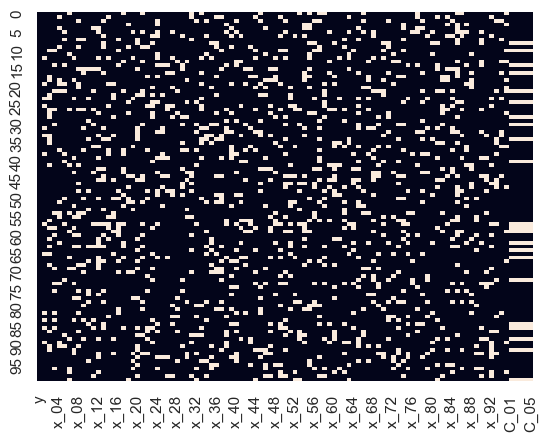

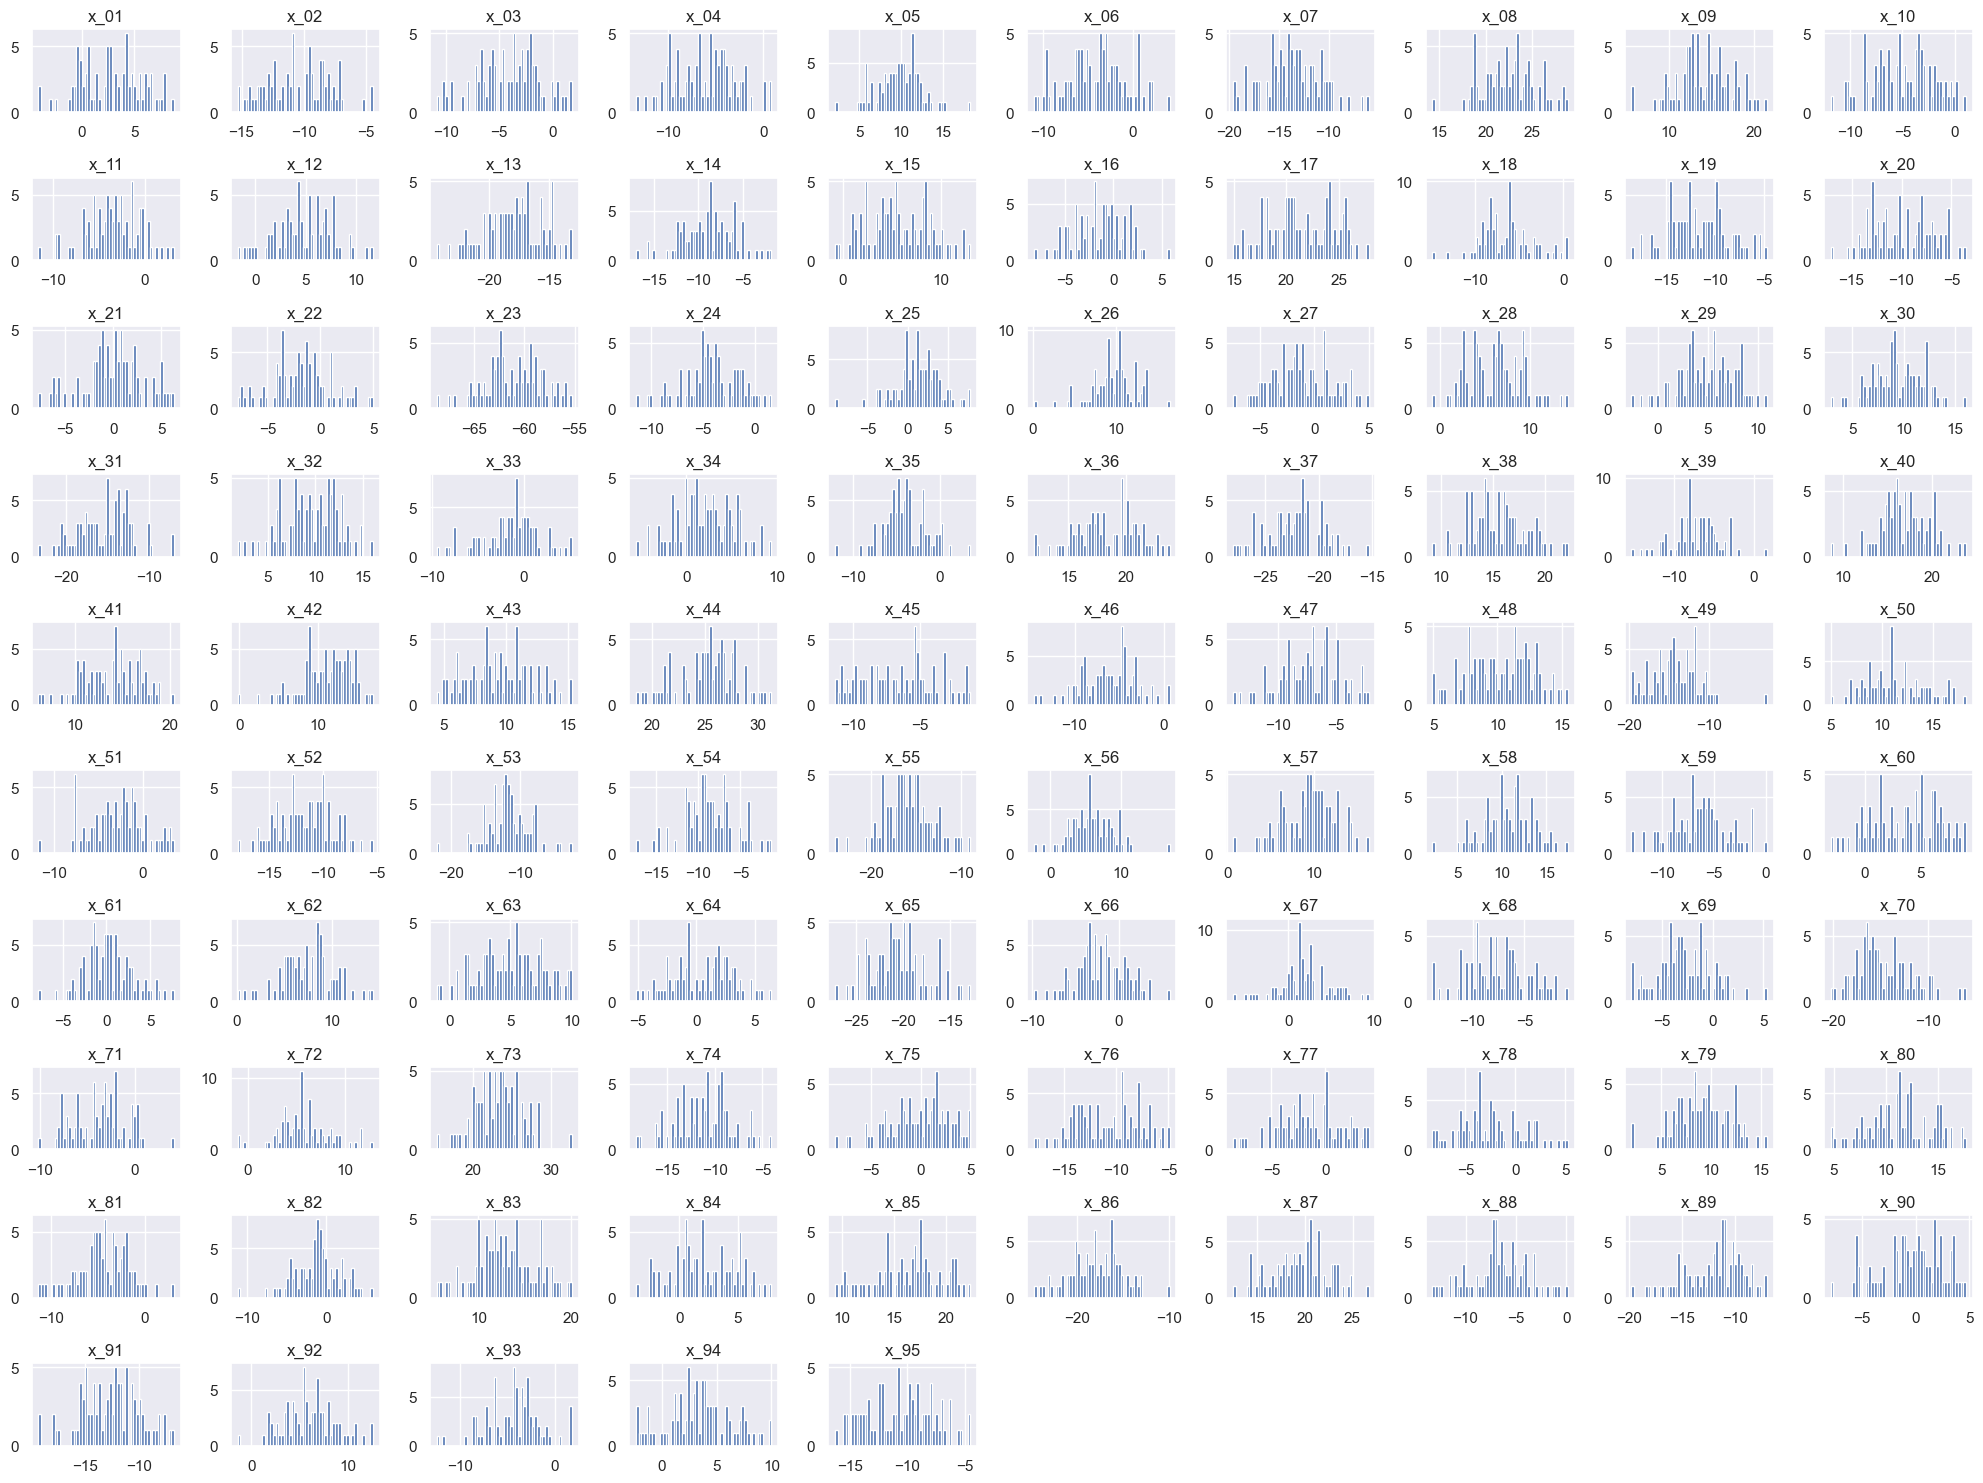

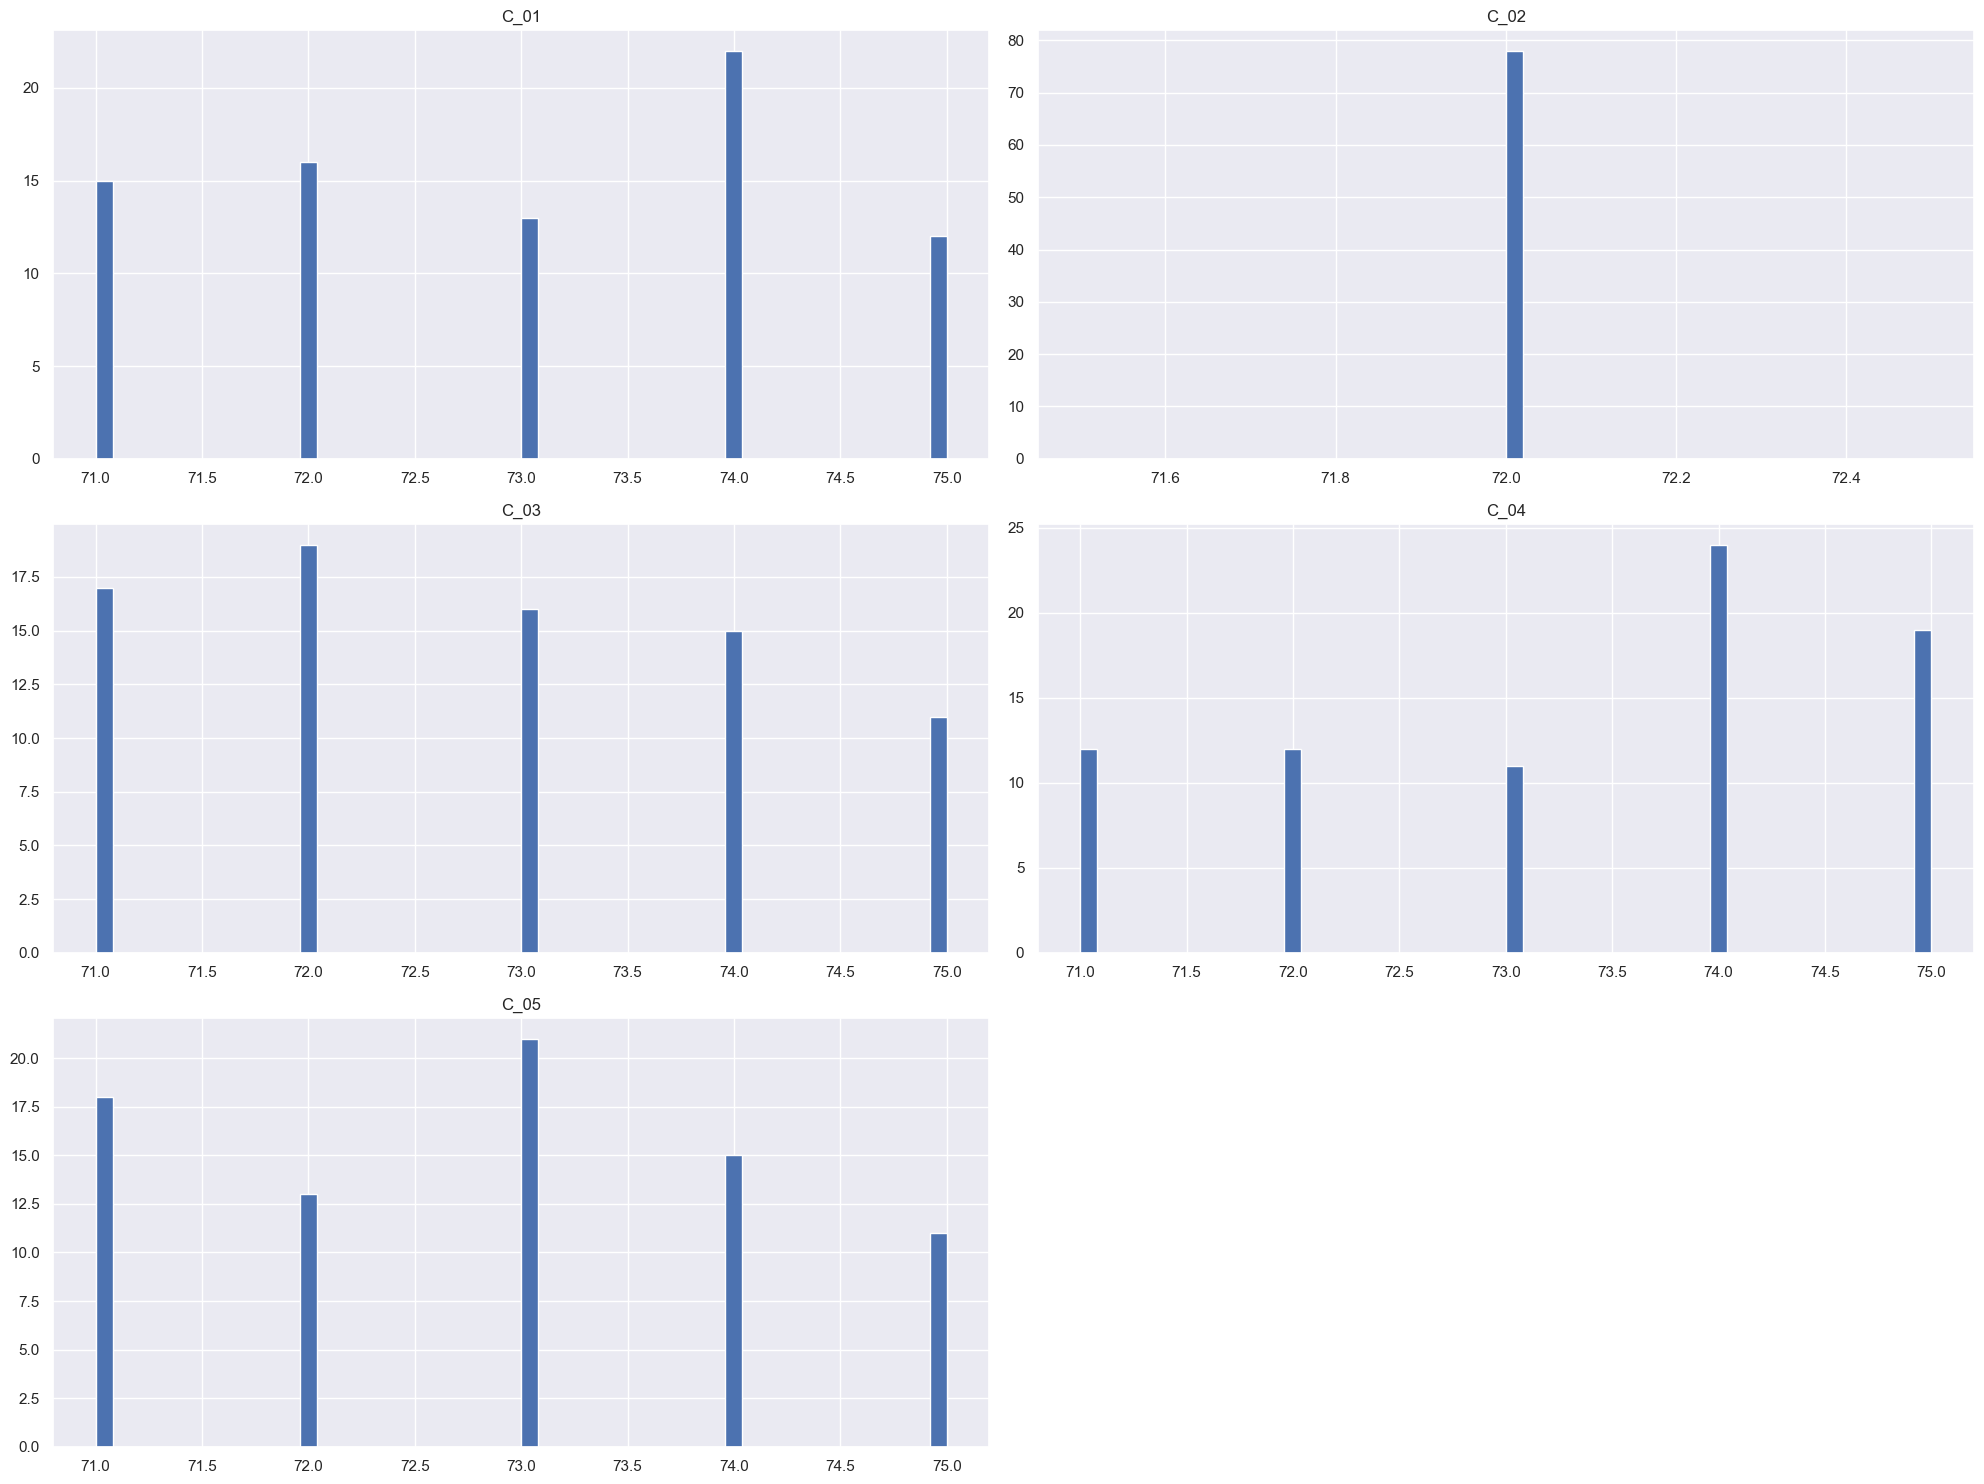

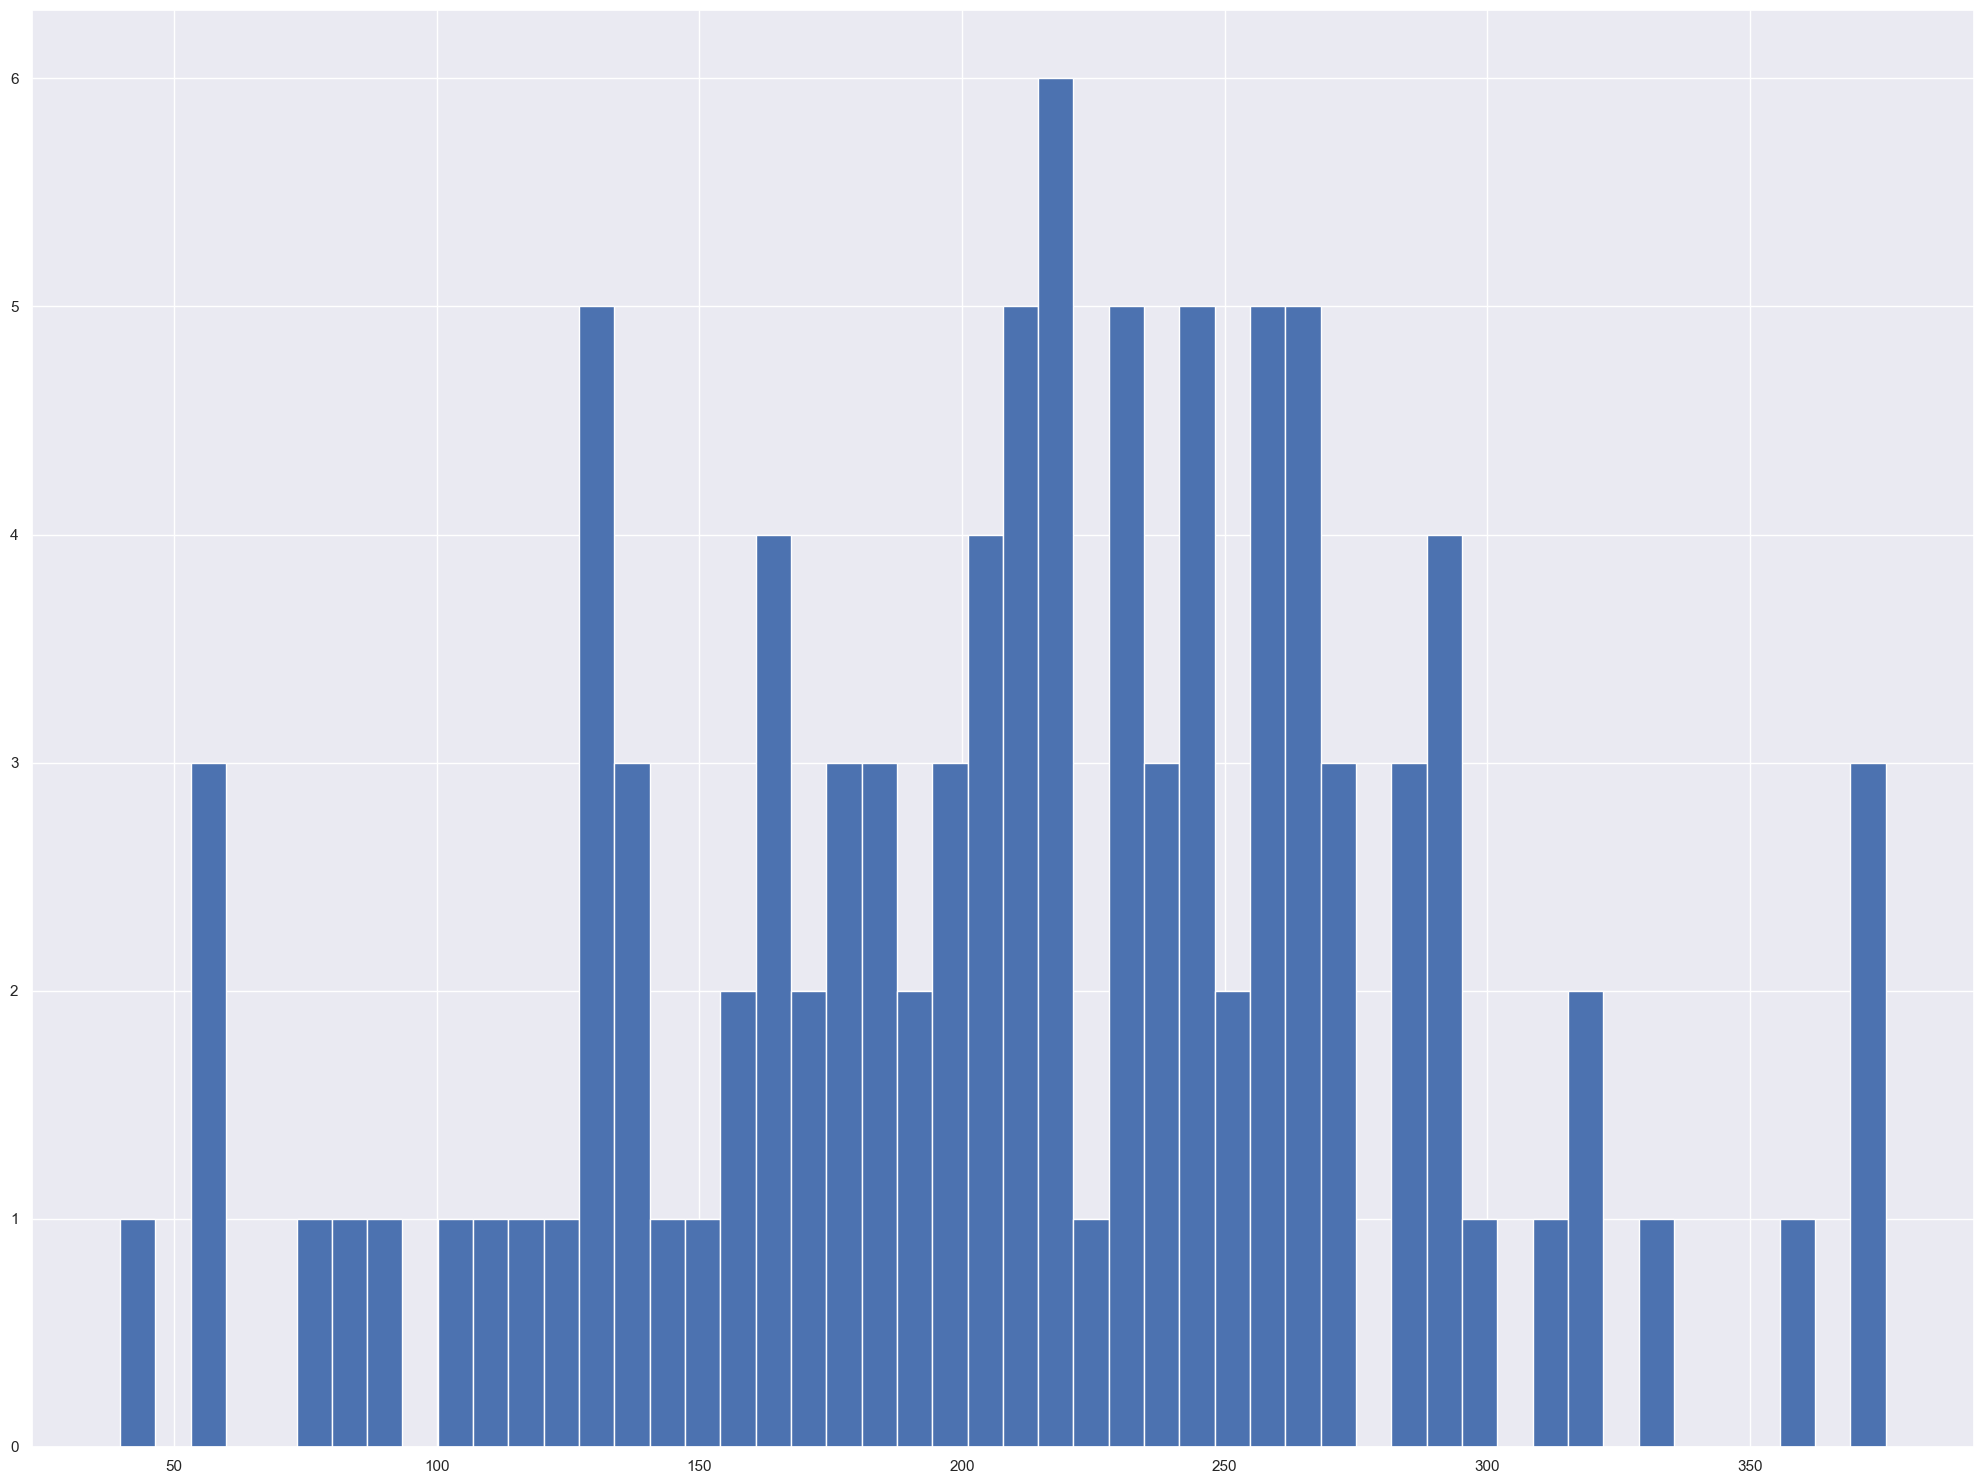

In [560]:
# Check for missing values
sns.heatmap(Data.isna(), cbar=False)


# Split data into X and y
X = Data.drop(columns=["y"])

num_features = X.columns[0:-5]
cat_features = X.columns[-5:]
columns = num_features.tolist() + cat_features.tolist()

y = Data['y']

n, p = X.shape

print("Training data")
print("Number of features: \t", X.shape[1])
print("Number of samples: \t", X.shape[0])

# Total percentage of missing values
print("Percentage of missing values: ", Data.isna().sum().sum()/(n*p)*100, "%")
print("")

print("y mean: ", y.mean())
print("y std: \t", y.std())

# Plot histrogram for all numerical features
ax = X[num_features].hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

# Plot histrogram for all numerical features
ax = X[cat_features].hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

ax = y.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()


### Split Into Training and Test Set

In [561]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=42, 
                                                    shuffle=True)

### Create Pipeline for Preprocessing

In [562]:
# Pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2)),  # Apply KNN Imputer for missing values
    ('transform', PowerTransformer(method='yeo-johnson', standardize=False)),  # Make distribution more normal
    ('scaler', RobustScaler()) # Scale the data
])

# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', 
                               unknown_value=-1, encoded_missing_value=-1)),  # Encode categorical data          
])

# Combine the two pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_features),
        ('cat', categorical_pipeline, cat_features)
    ])

# Define RMSE scorer
def neg_rmse(y_true, y_pred):
    """
    Negative RMSE for use in GridSearchCV
    """
    return -np.sqrt(mean_squared_error(y_true, y_pred))

# Define the scorer
rmse_scorer = make_scorer(neg_rmse)

# Find optimal lambda using 1 standard deviation rule
def se1_rule(results, K):
    """
    Find optimal lambda using 1 standard deviation rule
    """
    meanRMSE = -results['mean_test_score']
    seRMSE = results['std_test_score'] / np.sqrt(K)

    jOpt = np.argmin(meanRMSE)
    J = np.where(meanRMSE[jOpt] + seRMSE[jOpt] > meanRMSE)[0]
    j = int(J[-1])
    Lambda_CV_1StdRule = results['param_regressor__alpha'][j]

    print("_"*40)
    print("Lambda using 1 Standard error Rule: %.2f" % Lambda_CV_1StdRule)
    print("")
    return Lambda_CV_1StdRule

### Perform Cross-validation for Model Selection

In [563]:
# -- Cross Validation -- 
K = 10 # Number of folds
CV = KFold(n_splits=K, shuffle=True, random_state=42)

k = 25 # Number of values for alpha and l1_ratio

# Define the model pipline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=50000, random_state=42)),
])

# Define the parameter grid for GridSearchCV
param_grid = [
    {
    'regressor__alpha': np.logspace(-2, 1, k),
    'regressor__l1_ratio': np.linspace(0.01, 1, k)
    },
    {
    'regressor': [Ridge(max_iter=50000, random_state=42)],
    'regressor__alpha': np.logspace(-2, 1, k),
    }
    ]

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, 
                            scoring=rmse_scorer, 
                            cv=CV, 
                            n_jobs=-1,
                            verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

print("_"*62)
print("")
print("--- Cross Validation Results ---")
print("Best model: ", grid_search.best_estimator_['regressor'].__class__.__name__)
print("Best score: %.2f" % -grid_search.best_score_)
print("Best lambda value: %.2f" % grid_search.best_estimator_['regressor'].alpha)
print("Best l1 ratio value: %.2f" % grid_search.best_estimator_['regressor'].l1_ratio)

Fitting 10 folds for each of 650 candidates, totalling 6500 fits
______________________________________________________________

--- Cross Validation Results ---
Best model:  ElasticNet
Best score: 29.91
Best lambda value: 1.00
Best l1 ratio value: 1.00


________________________________________
Lambda using 1 Standard error Rule: 2.37

--- Test set results ---
Estimated RMSE: 24.15


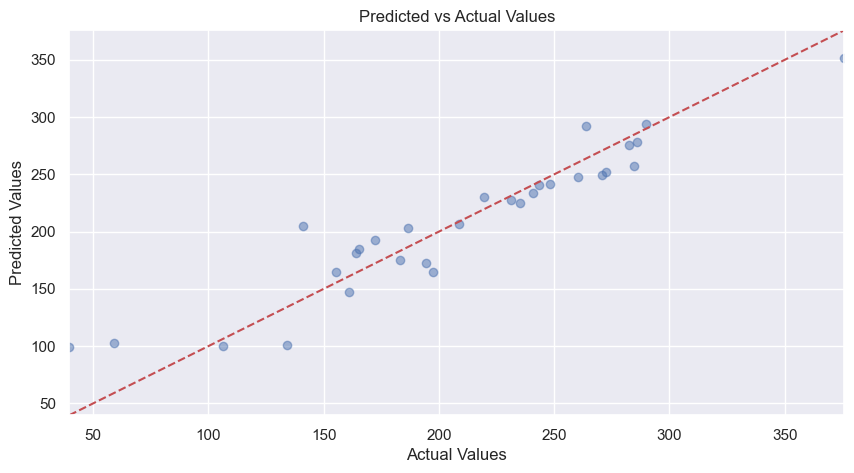

In [564]:
# -- Find optimal lambda using 1 standard error rule --
Lambda_CV_1StdRule = se1_rule(grid_search.cv_results_, K)

# -- Refit the model with the 1 se lambda value --
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=Lambda_CV_1StdRule, 
                              l1_ratio=grid_search.best_estimator_['regressor'].l1_ratio,
                              max_iter=50000, random_state=42))
])

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = RMSE(y_test, y_pred)
print("--- Test set results ---")
print("Estimated RMSE: %.2f" % rmse)

# -- Save RMSE to csv file --
rmse_df = pd.DataFrame([rmse])
rmse_df.to_csv('estimatedRMSE_s214786.csv', index=False, header=False)


# Plot the predicted vs actual values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.show()


### Predict on new data

In [565]:
# -- Predict on the new data --
model.fit(X, y)
y_pred = model.predict(X_new)

# Save the predictions to a CSV file
submission = pd.DataFrame([y_pred])
submission.to_csv('predictions_s214786.csv', index=False, header=False)
print("Predictions saved to predictions_s214786.csv")

Predictions saved to predictions_s214786.csv
